# Loading Libraries

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision
import numpy as np
import cv2
import re
import os
from glob import glob
from torch.utils.data import Dataset
from sklearn.metrics import jaccard_score
from PIL import Image
import matplotlib.pyplot as plt

# Model Architecture

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model_residue = torchvision.models.segmentation.fcn_resnet50(pretrained=True)
model_residue.classifier[4] = nn.Conv2d(512, 2, kernel_size=1)
model_residue.load_state_dict(torch.load("/content/residue_model.pth", map_location=device))
model_residue = model_residue.to(device)
model_residue.eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth
100%|██████████| 135M/135M [00:02<00:00, 62.1MB/s]
<ipython-input-5-55c1f1e85273>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pic

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [ ]:
model_sunlit = torchvision.models.segmentation.fcn_resnet50(pretrained=True)
model_sunlit.classifier[4] = nn.Conv2d(512, 2, kernel_size=1)
model_sunlit.load_state_dict(torch.load("/content/sunlit_model.pth", map_location=device))
model_sunlit = model_sunlit.to(device)
model_sunlit.eval()

<ipython-input-6-7eb4226d572f>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_sunlit.load_state_dict(torch.load("/content/sunlit_model.pth", map_location=device))


FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

# Load Image and Mask

In [ ]:
def load_image(img_path):
    image = cv2.imread(img_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def load_mask(img_path):
    mask_path = re.sub(r"(.*)(part\d+)(.*)\.jpg", r"\1res_\2\3.tif", img_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = np.where(mask == 255, 0, 1).astype(np.uint8)
    return mask

class ResidueDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = load_image(self.image_paths[idx])
        mask = load_mask(self.image_paths[idx])

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        else:
            image = torch.from_numpy(image).permute(2, 0, 1).float()
            mask = torch.tensor(mask, dtype=torch.long)

        image = image.float()
        mask = mask.long()

        return image, mask


In [ ]:
def load_image_sunlit(img_path):
    image = cv2.imread(img_path, cv2.IMREAD_COLOR)
    if image is None:
        raise FileNotFoundError(f"Image not found: {img_path}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def load_mask_sunlit(img_path):
    mask_path = re.sub(r"(IMG_\d+)_part(\d+)(\.\w+)", r"\1_sunshad_part\2.tif", img_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        raise FileNotFoundError(f"Mask not found: {mask_path}")
    mask = np.where(mask == 255, 0, 1).astype(np.uint8)
    return mask

class SunlitShadedDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = load_image_sunlit(self.image_paths[idx])
        mask = load_mask_sunlit(self.image_paths[idx])

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        else:
            image = torch.from_numpy(image).permute(2, 0, 1).float()
            mask = torch.tensor(mask, dtype=torch.long)

        image = image.float()
        mask = mask.long()

        return image, mask

# Calculate IoU Score

In [ ]:
def iou_score(pred_mask, true_mask, num_classes=2):
    iou_list = []
    for i in range(num_classes):
        intersection = np.sum((pred_mask == i) & (true_mask == i))
        union = np.sum((pred_mask == i) | (true_mask == i))
        iou = intersection / union if union != 0 else 0
        iou_list.append(iou)
    return np.mean(iou_list)

# Combine Segmentation

In [ ]:
def combine_segmentation(M1, M2):
    combined = np.zeros_like(M1)
    combined[(M1 == 1) & (M2 == 0)] = 1  # Residue Sunlit
    combined[(M1 == 1) & (M2 == 1)] = 2  # Residue Shaded
    combined[(M1 == 0) & (M2 == 0)] = 3  # Background Sunlit
    combined[(M1 == 0) & (M2 == 1)] = 4  # Background Shaded
    return combined

In [ ]:
residue_data_dir = "/content/drive/MyDrive/residue_background/Limbaugh1-1m20220328/IMG_0629"
sunlit_data_dir = "/content/drive/MyDrive/sunlit_shaded/Limbaugh1-1m20220328/IMG_0629"


In [ ]:
residue_image_paths = sorted(glob(os.path.join(residue_data_dir, "IMG_*_part*.jpg"), recursive=True))
sunlit_image_paths = sorted(glob(os.path.join(sunlit_data_dir, "IMG_*_part*.jpg"), recursive=True))


In [ ]:
residue_dataset = ResidueDataset(residue_image_paths)
sunlit_dataset = SunlitShadedDataset(sunlit_image_paths)

# IoU Loop

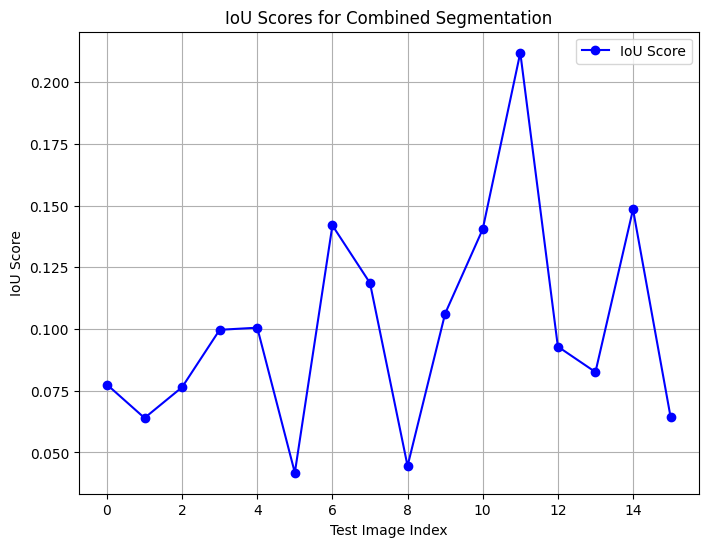

In [ ]:


# Function to compute IoU
def iou_score(pred, target, num_classes=2):
    # Ensure both pred and target are numpy arrays
    pred = pred.cpu().numpy() if isinstance(pred, torch.Tensor) else pred
    target = target.cpu().numpy() if isinstance(target, torch.Tensor) else target

    intersection = np.sum(pred * target)
    union = np.sum(pred) + np.sum(target) - intersection
    return intersection / union if union != 0 else 0

# Function to combine residue and sunlit segmentations (customize as per your requirement)
def combine_segmentation(residue_pred, sunlit_pred):
    # Example combining by taking maximum value at each pixel position
    combined = np.maximum(residue_pred, sunlit_pred)
    return combined

iou_scores = []
for i in range(len(residue_dataset)):
    # Load images and masks for both residue and sunlit
    residue_image, residue_mask = residue_dataset[i]
    sunlit_image, sunlit_mask = sunlit_dataset[i]

    # Perform inference with the models
    with torch.no_grad():
        residue_output = model_residue(residue_image.unsqueeze(0).to(device))["out"]
        sunlit_output = model_sunlit(sunlit_image.unsqueeze(0).to(device))["out"]

    # Convert the outputs to binary masks
    residue_pred = torch.argmax(residue_output.squeeze(), dim=0).cpu().numpy()
    sunlit_pred = torch.argmax(sunlit_output.squeeze(), dim=0).cpu().numpy()

    # Combine segmentations
    combined_pred = combine_segmentation(residue_pred, sunlit_pred)
    combined_mask = combine_segmentation(residue_mask, sunlit_mask)

    # Compute IoU
    iou = iou_score(combined_pred, combined_mask, num_classes=5)
    iou_scores.append(iou)

# Plot IoU scores
plt.figure(figsize=(8, 6))
plt.plot(iou_scores, marker='o', color='b', label='IoU Score')
plt.title('IoU Scores for Combined Segmentation')
plt.xlabel('Test Image Index')
plt.ylabel('IoU Score')
plt.grid(True)
plt.legend()
plt.show()

# Compute Avg IoU

In [ ]:
# Compute Average IoU
average_iou = np.mean(iou_scores)
print(f"Average IoU: {average_iou:.4f}")

Average IoU: 0.1008
